In [14]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import umap
import matplotlib.collections
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable


import scanpy as sc
import anndata as ad
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import amplicon_tools as at

In [15]:
if not 'path' in globals():
    path = os.getcwd()
print('path: ' + path)

variant_info_path = path + '/genotyping/genotyping.variants.tsv'
genotyping_hdf5_path = path + '/genotyping/genotyping.genotypes.hdf5'

experiments = []

path: /drive3/Cyrille/Gelbeads


In [16]:
# load in variant annotations
variant_info = at.load_variants(variant_info_path)

In [17]:
genotypes, quality, total_depth, alt_depth = at.load_genotypes(genotyping_hdf5_path)

In [18]:
# filter variant calls to remove low confidence asignments
at.filter_variants(genotypes, alt_depth, total_depth, quality, 
                   min_alt_depth=5, min_total_depth=20, min_quality=30)

,:chr1:115256325:A/,:chr1:115256326:A/,CSDE1:chr1:115256327:A/G,CSDE1:chr1:115256328:A/G,CSDE1:chr1:115256329:A/G,:chr1:115256330:G/,:chr1:115256331:C/,CSDE1:chr1:115256332:T/C,:chr1:115256333:C/,CSDE1:chr1:115256334:T/A,...,U2AF1:chr21:44524496:A/G,:chr21:44524497:A/,U2AF1:chr21:44524498:A/G,U2AF1:chr21:44524499:A/G,:chr21:44524500:T/,U2AF1:chr21:44524501:G/A,U2AF1:chr21:44524502:A/G,U2AF1:chr21:44524503:A/G,:chr21:44524504:C/,U2AF1:chr21:44524505:A/C
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AACAACCGAATCGCCTGCGTTATG-0,3,3,0,0,0,3,3,0,3,0,...,0,3,0,0,3,0,0,0,3,0
AACAACCGACAATGCCACGCTTGT-0,3,3,0,0,0,3,3,0,3,0,...,0,3,0,0,3,0,0,0,3,0
AACAACCGAGTGGTACCCTGGAAT-0,3,3,0,0,0,3,3,0,3,0,...,3,3,3,3,3,3,3,3,3,3
AACAACCGATGTTGGCAATGCAGC-0,3,3,1,0,0,3,3,0,3,0,...,0,3,0,0,3,0,0,0,3,0
AACAACCGCAGAACACAACGGAAG-0,3,3,0,0,0,3,3,0,3,0,...,0,3,0,0,3,0,0,0,3,0
AACAACCGCAGTAAGGAAGGATCC-0,3,3,0,0,0,3,3,0,3,0,...,3,3,3,3,3,3,3,3,3,3
AACAACCGGACCATACGCTATTCG-0,3,3,0,0,0,3,3,0,3,0,...,3,3,3,3,3,3,3,3,3,3
AACACGACAACACGACGACCATAC-0,3,3,0,0,0,3,3,0,3,0,...,3,3,3,3,3,3,3,3,3,3
AACACGACACTTCGGTACCGAATC-0,3,3,0,0,0,3,3,0,3,0,...,3,3,3,3,3,3,3,3,3,3


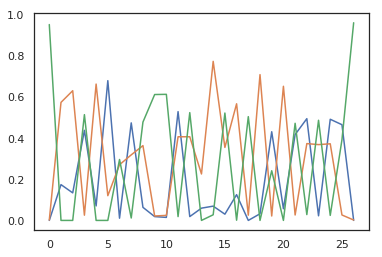

In [19]:
# identify variants which are non wild type for many cells
call1 = ((np.array(genotypes) == 3).sum(axis=0)+(np.array(genotypes) == 0).sum(axis=0))/1022. < .90
plt.plot((np.array(genotypes) == 0).sum(axis=0)[call1]/1022.)
plt.plot((np.array(genotypes) == 1).sum(axis=0)[call1]/1022.)
plt.plot((np.array(genotypes) == 2).sum(axis=0)[call1]/1022.)
#plt.plot((np.array(genotypes) == 3).sum(axis=0))

In [20]:
# cluster similar cellls
exp = at.Cluster_cells.read_hd5(np.array(genotypes)[:-2,:], allel_traits=(1,2), merged=False) 
exp.cell_identity(dense_dot=True)

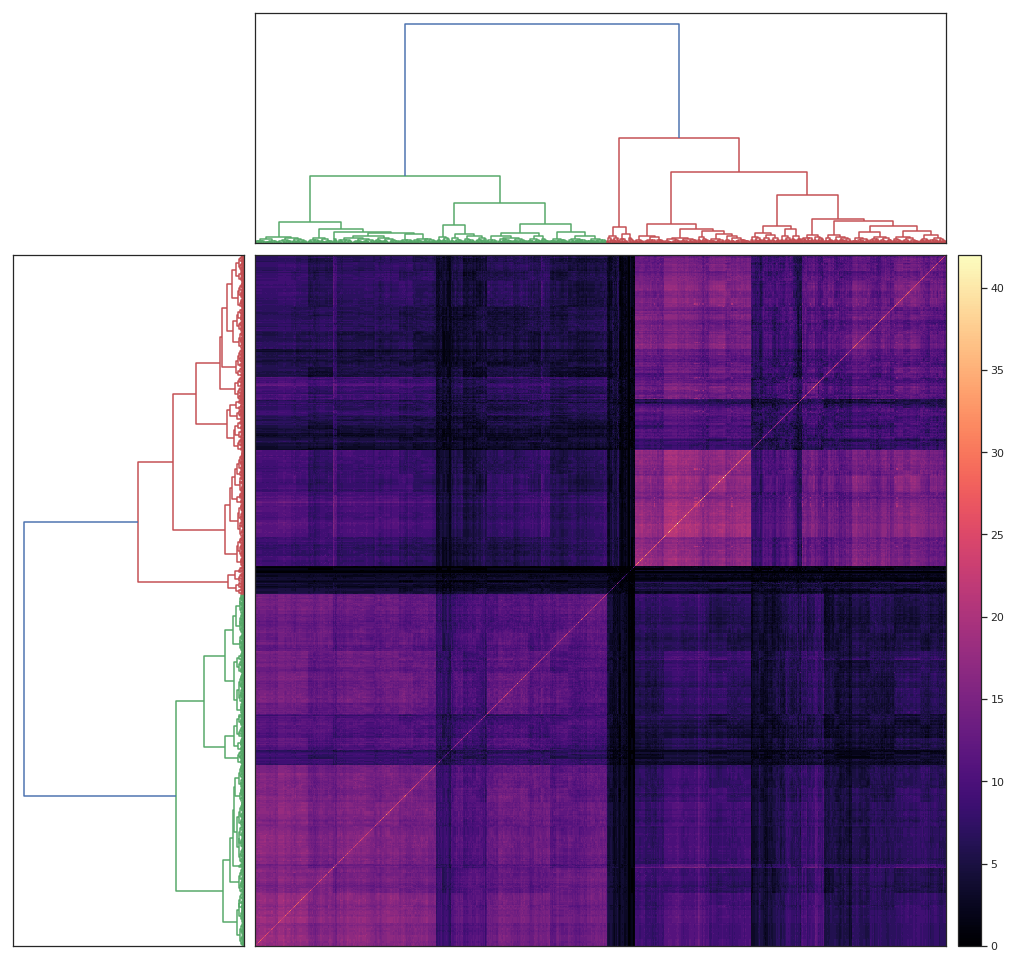

In [22]:
# plot the sorted cell by cell matrix
exp.make_cluster('ward', cmap='magma') #, exp.cos_sim

In [23]:
exp.retrieve_cluster(2)

In [24]:
raij = np.array(genotypes)[-1,:] # bulk sample
K562 = np.array(genotypes)[-2,:] # bulk sample
cells = np.array(genotypes)[:-2,:]

In [25]:
geno = np.array(genotypes==1).astype(int)

In [26]:
reducer = umap.UMAP(metric='jaccard')
embedding = reducer.fit_transform(geno, )
embedding.shape

(1028, 2)

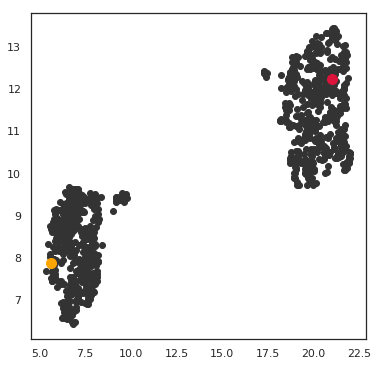

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(embedding[:-2, 0], embedding[:-2, 1], c='0.2', cmap='Greys', vmin=0, vmax=1, alpha=1)#exp.clusters[:]
ax.scatter(embedding[-1, 0], embedding[-1, 1], c='orange', s=100)
ax.scatter(embedding[-2, 0], embedding[-2, 1], c='crimson', s=100)
plt.show()

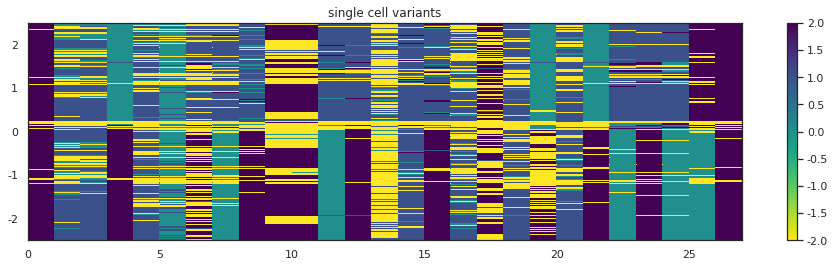

In [28]:
data = np.array(genotypes)[:-2,call1][exp.cell_sort_idx,]
data[data==3] = -2

data2 = np.array(genotypes)[-2:,call1]
data2[data2==3] = -2

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-2.5, 2.5, data.shape[0]+1), np.linspace(0, data.shape[1], data.shape[1]+1))
z = data
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots(1,1, figsize=(16,4))

c = ax.pcolormesh(x, y, z.T, cmap='viridis_r', vmin=z_min, vmax=z_max, rasterized=True)
ax.set_title('single cell variants')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.savefig('cell_variant_1.svg')
plt.show()

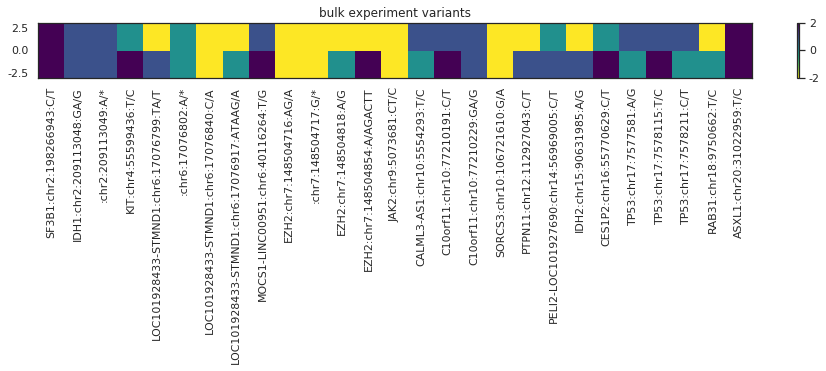

In [29]:
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 3), np.linspace(0, data.shape[1],data.shape[1]+1))
z = data2
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots(1,1, figsize=(16,1))

c = ax.pcolormesh(x, y, z.T, cmap='viridis_r', vmin=z_min, vmax=z_max)
ax.set_title('bulk experiment variants')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

ax.set_xticks(np.arange(len(genotypes.columns[call1]))+.5)
ax.set_xticklabels(np.array(genotypes.columns[call1]), rotation=90)

plt.savefig('cellline_variant_1.svg')
plt.show()

In [30]:
for i, j in zip(list(genotypes.index[-3:]), np.array(genotypes)[-3:,call1]):
    print(i, j)

TTGTTCCGTCCGTAGTACAATGCC-0 [2 1 1 0 3 3 3 3 0 3 3 1 1 1 1 3 3 3 1 0 1 0 1 1 1 2 2]
TTGTTCCGTTCCGCTTAACAACCG-0 [2 1 1 2 1 0 3 0 2 3 3 0 2 3 0 2 1 3 1 1 1 2 0 2 0 0 2]
TTGTTCCGTTCCGCTTAAGAGGCA-0 [2 1 1 0 3 0 3 3 1 3 3 3 3 3 1 1 1 3 3 0 3 0 1 1 1 3 2]


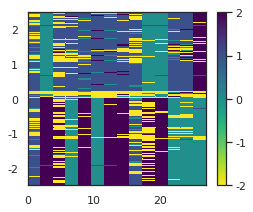

In [31]:
diff = np.array([False,  True, False,  True, False, False,  True,  True,  True,
       False, False,  True,  True, False, False,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True, False])

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-2.5, 2.5, data.shape[0]+1), np.linspace(0, data.shape[1], sum(diff)+1))
z = data[:,diff]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots(1,1, figsize=(4,3*1.06))

c = ax.pcolormesh(x, y, z.T, cmap='viridis_r', vmin=z_min, vmax=z_max, rasterized=True)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.savefig('cell_variant_2.svg', dpi = 600)
plt.show()

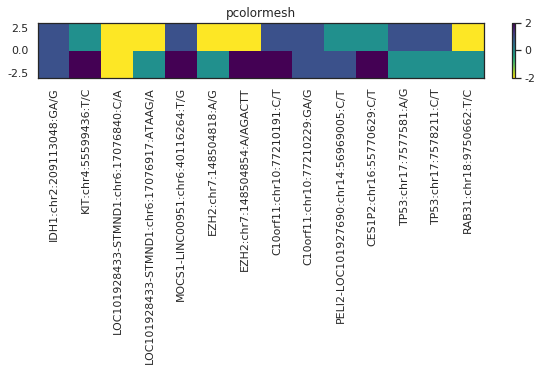

In [32]:
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 3), np.linspace(0, sum(diff),sum(diff)+1))
z = data2[:, diff]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots(1,1, figsize=(10,1))

c = ax.pcolormesh(x, y, z.T, cmap='viridis_r', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

ax.set_xticks(np.arange(len(genotypes.columns[call1][diff]))+.5)
ax.set_xticklabels(np.array(genotypes.columns[call1][diff]), rotation=90)

plt.savefig('cellline_variant_2.svg')
plt.show()